In [2]:
# Import all modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
import torch
from scipy.stats.stats import pearsonr      

/home/joonsikk/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
## Load all the intermediate outputs of the network for faster computation

num_classes = 10 #    
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# x_train - training data(images), y_train - labels(digits)

with open("../data/weight_matrix_Cifar.pkl", "rb") as input_file:
    [weight_matrix,y_predict] = pickle.load(input_file)
    
output_test = pickle.load(open('../data/output_test_cifar.pkl', 'rb'))
output_test_labels = np.argmax(output_test, axis=1)
output_train_labels = np.argmax(y_predict, axis=1)

with open('../data/intermediate34_train.pkl' , 'rb') as f:
    train_output34 = pickle.load(f)
    
with open('../data/intermediate34_test.pkl', 'rb') as f:
    test_output34 = pickle.load(f)
    
with open('../data/intermediate36_train.pkl' , 'rb') as f:
    train_output36 = pickle.load(f)
    
with open('../data/intermediate36_test.pkl', 'rb') as f:
    test_output36 = pickle.load(f)
    
with open('../data/presoft_test.pkl', 'rb') as f:
    presoft_test = pickle.load(f)

def compute_pearson(x, y):
    numer = np.sum((x - np.mean(x)) * (y - np.mean(y)))
    denom = np.sqrt(np.sum((x - np.mean(x)) ** 2)) * np.sqrt(np.sum((y - np.mean(y)) ** 2))
    return numer / denom


In [4]:
## Calculate correlations and mean differences for training and testing

tensor_train34 = torch.FloatTensor(train_output34)
tensor_test34 = torch.FloatTensor(test_output34)

w_tensor = torch.FloatTensor(weight_matrix)
prod_train = torch.matmul(torch.t(tensor_train34),w_tensor)
prod_train_test = torch.matmul(tensor_test34.cuda(), prod_train.cuda())
prod_train_train = torch.matmul(tensor_train34.cuda(), prod_train.cuda())

prod_train_test = prod_train_test - torch.max(prod_train_test,1,True)[0]
prod_train_train = prod_train_train - torch.max(prod_train_train,1,True)[0]

D_exp_train_test = torch.exp(prod_train_test)
D_exp_sum_train_test = torch.sum(D_exp_train_test, dim=1).view(10000,1)

D_exp_train_train = torch.exp(prod_train_train)
D_exp_sum_train_train = torch.sum(D_exp_train_train, dim=1).view(50000,1)

y_p_train_train = D_exp_train_train.div(D_exp_sum_train_train.expand_as(D_exp_train_train))
y_p_train = y_p_train_train.cpu().numpy()

y_p_train_test = D_exp_train_test.div(D_exp_sum_train_test.expand_as(D_exp_train_test))
y_p_test = y_p_train_test.cpu().numpy()

Y_test = test_output36 
Y_train = train_output36
print('Absolute Mean Diff: {}, {}'.format(np.mean(np.abs(Y_train-y_p_train)), np.mean(np.abs(Y_test-y_p_test))))
corr_train,_ = (pearsonr((Y_train).flatten(),(y_p_train).flatten()))
corr_test,_ = (pearsonr((Y_test).flatten(),(y_p_test).flatten()))
print('Correlations: {}, {}'.format(corr_train, corr_test))


Absolute Mean Diff: 0.005856770556420088, 0.00961466133594513
Correlations: 0.988909900188446, 0.9824426174163818


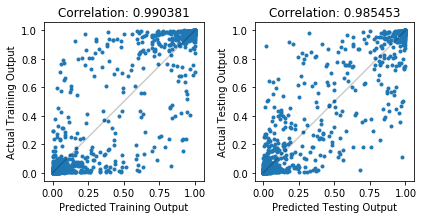

In [31]:
## Plot subset of the data

np.random.seed(801)
train_rand_idx = np.random.choice(50000, 2000, replace=False)
np.random.seed(4)
test_rand_idx = np.random.choice(10000, 1000, replace=False)

corr_train_part,_ = (pearsonr((Y_train[train_rand_idx]).flatten(),(y_p_train[train_rand_idx]).flatten()))
corr_test_part,_ = (pearsonr((Y_test[test_rand_idx]).flatten(),(y_p_test[test_rand_idx]).flatten()))

fig, ax = plt.subplots(1,2)

ax[0].scatter(y_p_train[train_rand_idx], Y_train[train_rand_idx], marker='.')
ax[0].plot([0, 1], [0, 1], 'k-', alpha=0.2, zorder=1)
ax[0].set_title('Correlation: %f'%corr_train_part)
ax[0].set_xlabel('Predicted Training Output')
ax[0].set_ylabel('Actual Training Output')
ax[0].set_aspect('equal')

ax[1].scatter(y_p_test[test_rand_idx], Y_test[test_rand_idx], marker='.')
ax[1].plot([0, 1], [0, 1], 'k-', alpha=0.2, zorder=1)
ax[1].set_title('Correlation: %f'%corr_test_part)
ax[1].set_xlabel('Predicted Testing Output')
ax[1].set_ylabel('Actual Testing Output')
ax[1].set_aspect('equal')
plt.tight_layout()
plt.savefig('correlation.png', dpi=200)